<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-просмотр-данных" data-toc-modified-id="Загрузка-и-просмотр-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и просмотр данных</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#LinearSVC" data-toc-modified-id="LinearSVC-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LinearSVC</a></span></li><li><span><a href="#LGBMClassifier" data-toc-modified-id="LGBMClassifier-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LGBMClassifier</a></span></li><li><span><a href="#Тестирование-лучшей-модели" data-toc-modified-id="Тестирование-лучшей-модели-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Тестирование лучшей модели</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Проект для «Викишоп»

**Цель проекта**:<br>
Разработать модель машинного обучения для автоматического определения токсичных пользовательских комментариев на платформе «Викишоп» с использованием методов обработки естественного языка. Модель должна достигать значения метрики F1 не ниже 0.75 для обеспечения надежной фильтрации негативного контента.

**Описание проекта:**<br>
Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Построим модель со значением метрики качества *F1* не меньше 0.75. 

**План по выполнению проекта:**
1. Загрузим и подготовим данные.
2. Обучим разные модели. 
3. Сделаем выводы.

**Описание данных:**<br>
Данные находятся в файле `toxic_comments.csv`. Столбец `text` в нём содержит текст комментария, а `toxic` — целевой признак.

## Загрузка и просмотр данных

In [1]:
# Подключение всех необходимых библиотек
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import f1_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from lightgbm import LGBMClassifier

# Настройка pandas для отображения полного текста
pd.set_option('display.max_colwidth', None)

# Задаем стиль графиков
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Загружает CSV-файл и выводит случайные строки и общую информацию
def load_and_inspect_csv(filepath, delimiter=',', sample_size=10):
    if os.path.exists(filepath):
        df = pd.read_csv(filepath, delimiter=delimiter, index_col=0)
        print(f"Файл успешно загружен: {filepath}")
        display(df.sample(sample_size, random_state=42))
        df.info()
        return df
    else:
        print(f"Файл не найден: {filepath}")
        return None

In [3]:
# Изучим данные
df = load_and_inspect_csv('/datasets/toxic_comments.csv')

Файл успешно загружен: /datasets/toxic_comments.csv


,text,toxic
31055,"Sometime back, I just happened to log on to www.izoom.in with a friend’s reference and I was amazed to see the concept Fresh Ideas Entertainment has come up with. So many deals… all under one roof. This website is very user friendly and easy to use and is fun to be on.\nYou have Gossip, Games, Facts… Another exciting feature to add to it is Face of the Week… Every week, 4 new faces are selected and put up as izoom faces. It’s great to have been selected in four out of a group of millions. \nThis new start up has already got many a deals in its kitty. Few of them being TheFortune Hotel, The Beach… are my personal favorites. izoom.in has a USP of mobile coupons. Coupons are available even when a user cannot access internet. You just need to SMS izoom support to 56767 and you get attended immediately.\nAll I can say is izoom.in is a must visit website for everyone before they go out for shopping or dining or for outing.\nCheers!!!",0
102929,"""\n\nThe latest edit is much better, don't make this article state """"super."""" at all. 71.237.70.49 """,0
67385,""" October 2007 (UTC)\n\nI would think you'd be able to get your point across, and be immune to any objections, were you to simply embellish the second sentence of the article by changing """"he was schooled at Thornleigh Salesian College"""" to """"he was schooled at (the then all-Catholic) Thornleigh Salesian College"""". \n\nGood suggestion from an Anon - what do you think? Rgds, - 07:53, 5""",0
81167,Thanks for the tip on the currency translation. Think it's all done now.,0
90182,"I would argue that if content on the Con in comparison to the Arts Music is out of proportion, then it warrants further contribution to the article, not the removal of an indepth piece of content. Also, as I mentioned before, the Arts Music unit has a notable history comparable to that of the Con itself. Because of this, I would further argue that content on the Arts Music Unit is more relevant to this article than the information on the Newcastle Conservatorium.",0
1860,"""=Reliable sources===\nCheating:\n""""Barry Bonds:Cheater"""" from CBS, yea I kinda think that is reliable. \n""""Dear Barry Bonds, You are either an outright cheater or very stupid"""" from the USA Today \n""""Yes, Barry Bonds is a cheater. He is a cheater of the worst sort"""" \nLying:\n""""It's clear, Barry Bonds' a liar"""" New York Daily News, another pretty freakin' reliable source. \n""""Barry Lamar Bonds is a bad man"""" Baseball Digest \n""""but Bonds is a liar, a cheater, a whiner and a bad influence on America's youth"""" Mark Barnes\n\n==""",1
125422,WTF=\n\nHow The Fuck Does This Person Merit A Page On Wikipedia.,1
149142,"cajuns, acadians\nCajuns, acadians, louisianans, they're so many different names for different americans of french descent because their culture is so rich and somewhat so different but so close at the same time. I'm an acadian but more importantly I'm a french american so I really don't see why there should be a difference. \n\nIf you say there should be two different list, it doesn't make sense. The people on the french-american list should be in one of wiki-invented list of cajuns or acadians. I understand there are some more recent french-americans who are only 1 or 2 generations-old americans but this distinction isn't made for italian-americans, german-americans. I'm surprised to see Albert Einstein a fairly recent immigrant in American history next to Katherine Heigl, a 10 to 12 generations american. \\\n\nThis is all race-based, biased because french-bashing don't stop at the bush government level.",0
89784,"Hi - I dropped a pin in Google Maps at the ceremonial site near Chief Tayak's grave and recorded the lat/long. Is this not permitted? It maps correctly in other sites, as well, so I believe they're the correct coordinates. I live nearby, so could also visit the site and get the coordinates from GPS.",0
64323,Re removal of accessdate= for urls books \n\nThis is from T

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Таким образом, мы загрузили и изучили наши данные.

## Подготовка

Изучим распределение классов, а также проверим, есть ли пустые строки или аномалии в столбце `text`.

In [4]:
# Распределение классов
df['toxic'].value_counts(normalize=True)

0    0.898388
1    0.101612
Name: toxic, dtype: float64

In [5]:
# Проверка на пустые строки
print(df['text'].isnull().sum())
(df['text'].str.strip() == '').sum()

0


0

Только ~10% комментариев помечены как токсичные. Это важно учитывать при обучении – дисбаланс может повлиять на качество модели. Будем использовать F1-меру как основную метрику, а также применим стратификацию.

Теперь необходимо очистить текст и преобразовать его в числовой формат.

In [6]:
# Функция очистки текста
def preprocess_text(text):
    text = text.lower()  # приведение к нижнему регистру
    text = re.sub(r'<.*?>', '', text)  # удаление HTML-тегов
    text = re.sub(r'[^a-z\s]', '', text)  # удаление пунктуации и чисел
    text = re.sub(r'\s+', ' ', text).strip()  # удаление лишних пробелов
    return text

In [7]:
# Сделаем класс для добавления его в пайплайн
class TextCleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.apply(preprocess_text)

In [8]:
# Стратифицированное разбиение
df_trainval, df_test = train_test_split(df, test_size=0.2, stratify=df['toxic'], random_state=42)
df_train, df_valid = train_test_split(df_trainval, test_size=0.2, stratify=df_trainval['toxic'], random_state=42)

# X и y по подвыборкам
X_train = df_train['text']
y_train = df_train['toxic']

X_valid = df_valid['text']
y_valid = df_valid['toxic']

X_test = df_test['text']
y_test = df_test['toxic']

## Обучение

Создадим универсальную функцию для оценки модели на валидационной выборке.

In [9]:
def evaluate_on_validation(model, X, y, model_name='Model'):
    y_pred = model.predict(X)
    f1 = f1_score(y, y_pred)
    print(f'F1-score ({model_name}): {f1:.4f}')
    print('\nClassification Report:')
    print(classification_report(y, y_pred))

    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['not toxic', 'toxic'],
                yticklabels=['not toxic', 'toxic'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix – {model_name}')
    plt.show()
    
    return f1

Добавим возможность подбирать гиперпараметры через `GridSearchCV`.

In [10]:
def train_with_pipeline_and_gridsearch(estimator, param_grid, X_train, y_train, cv=3):
    pipeline = Pipeline([
        ('cleaner', TextCleaner()),
        ('tfidf', TfidfVectorizer(max_features=50000, ngram_range=(1, 2))),
        ('clf', estimator)
    ])
    
    grid = GridSearchCV(
        pipeline,
        param_grid,
        scoring='f1',
        cv=cv,
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)
    print(f'Best params: {grid.best_params_}')
    return grid.best_estimator_

Теперь проверим 3 различные модели.

### LogisticRegression

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params: {'clf__C': 10}
F1-score (Logistic Regression): 0.7590

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     22897
           1       0.73      0.79      0.76      2590

    accuracy                           0.95     25487
   macro avg       0.85      0.88      0.87     25487
weighted avg       0.95      0.95      0.95     25487



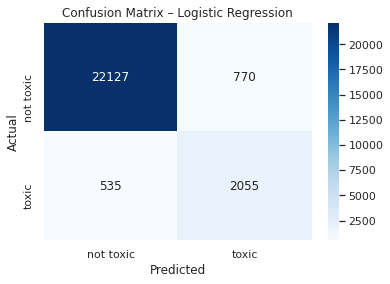

0.7590027700831024

In [11]:
# Модель
logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# Сетка гиперпараметров
logreg_grid = {
    'clf__C': [0.1, 1, 5, 10]
}

# Обучение с подбором параметров
best_logreg = train_with_pipeline_and_gridsearch(logreg, logreg_grid, X_train, y_train)

# Оценка на валидации
evaluate_on_validation(best_logreg, X_valid, y_valid, 'Logistic Regression')

После подбора гиперпараметра `C` с помощью `GridSearchCV` (лучшее значение: `C = 10`) модель логистической регрессии достигла F1-score = 0.7590 на валидационной выборке.

Модель продемонстрировала стабильный баланс между точностью (precision = 0.73) и полнотой (recall = 0.79) при определении токсичных комментариев. Общая точность классификации составила 95 %, что подтверждает надёжность модели в задаче автоматической модерации пользовательского контента.

### LinearSVC

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best params: {'clf__C': 1}
F1-score (LinearSVC): 0.7525

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     22897
           1       0.72      0.79      0.75      2590

    accuracy                           0.95     25487
   macro avg       0.85      0.88      0.86     25487
weighted avg       0.95      0.95      0.95     25487



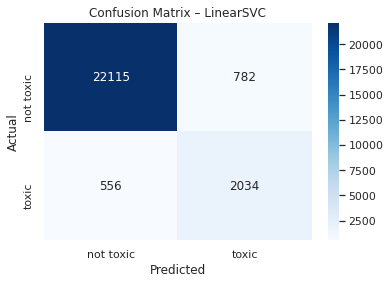

0.7524972253052165

In [12]:
# Модель
svc = LinearSVC(class_weight='balanced', max_iter=10000, random_state=42)

# Сетка гиперпараметров
svc_grid = {
    'clf__C': [0.1, 1, 5]
}

# Обучение с подбором параметров
best_svc = train_with_pipeline_and_gridsearch(svc, svc_grid, X_train, y_train)

# Оценка на валидации
evaluate_on_validation(best_svc, X_valid, y_valid, 'LinearSVC')

По результатам `GridSearchCV` был подобран оптимальный параметр `C = 1`. Модель LinearSVC достигла F1-score = 0.7525 на валидационной выборке, показав стабильные результаты при классификации токсичных комментариев, минимально уступая LogisticRegression.

Модель обеспечила хорошее соотношение точности (precision = 0.72) и полноты (recall = 0.79) для токсичного класса. Общая точность составила 95 %, что делает LinearSVC эффективным и устойчивым инструментом в задаче фильтрации пользовательского контента.

### LGBMClassifier

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best params: {'clf__learning_rate': 0.1, 'clf__n_estimators': 300, 'clf__num_leaves': 63}
F1-score (LightGBM): 0.7596

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     22897
           1       0.73      0.80      0.76      2590

    accuracy                           0.95     25487
   macro avg       0.85      0.88      0.87     25487
weighted avg       0.95      0.95      0.95     25487



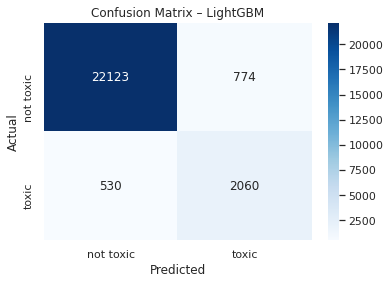

0.7595870206489675

In [13]:
# Модель
lgbm = LGBMClassifier(class_weight='balanced', random_state=42)

# Сетка гиперпараметров
lgbm_grid = {
    'clf__n_estimators': [100, 300],
    'clf__learning_rate': [0.05, 0.1],
    'clf__num_leaves': [31, 63]
}

# Обучение с подбором параметров
best_lgbm = train_with_pipeline_and_gridsearch(lgbm, lgbm_grid, X_train, y_train)

# Оценка на валидации
evaluate_on_validation(best_lgbm, X_valid, y_valid, 'LightGBM')

По результатам `GridSearchCV` наилучшими параметрами оказались: `learning_rate = 0.1`, `n_estimators = 300`, `num_leaves = 63`. Обученная модель LightGBM достигла F1-score = 0.7596 на валидационной выборке.

Модель продемонстрировала хороший баланс между точностью (precision = 0.73) и полнотой (recall = 0.80), а также общую точность 95 %. Качество классификации оказалось сопоставимо с результатами логистической регрессии и LinearSVC.

С учётом достигнутых метрик, модель **LightGBM** выбрана для финальной оценки на тестовой выборке.

### Тестирование лучшей модели

F1-score (LightGBM (Test)): 0.7721

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     28622
           1       0.74      0.81      0.77      3237

    accuracy                           0.95     31859
   macro avg       0.86      0.89      0.87     31859
weighted avg       0.95      0.95      0.95     31859



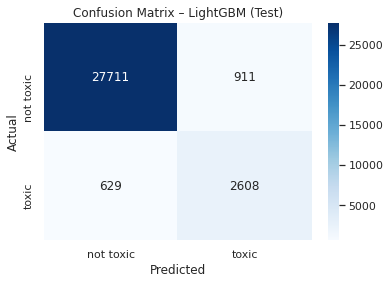

0.7720544701006512

In [15]:
# Финальная проверка лучшей модели на тесте
evaluate_on_validation(best_lgbm, X_test, y_test, 'LightGBM (Test)')

Выбранная по результатам валидации модель LightGBM была протестирована на ранее неиспользуемой тестовой выборке. Модель достигла F1-score = 0.7721, подтвердив свою устойчивость и способность обобщать на новых данных.

Модель продемонстрировала высокую полноту (recall = 0.81) и хорошую точность (precision = 0.74) при классификации токсичных комментариев. Общая точность составила 95 %, что соответствует показателям на валидации и подтверждает надёжность модели.

Таким образом, модель успешно прошла финальную проверку и может быть рекомендована для внедрения в систему автоматической модерации пользовательских комментариев.

## Общий вывод

В рамках проекта была решена задача автоматической классификации пользовательских комментариев на токсичные и нетоксичные для интернет-магазина «Викишоп». Цель состояла в разработке модели, способной выявлять токсичные сообщения с F1-метрикой не ниже 0.75. В распоряжении находился размеченный текстовый датасет объёмом более 150 тысяч комментариев.

После предварительного анализа и очистки данные были приведены к единому формату. Для исключения утечки информации в процессе векторизации был реализован сквозной Pipeline, включающий очистку текста, TF-IDF-векторизацию (c униграммами и биграммами) и классификатор. Для компенсации дисбаланса классов использовался параметр `class_weight='balanced'`. Данные были разделены на обучающую, валидационную и тестовую выборки. Подбор гиперпараметров всех моделей выполнялся на обучающей выборке с использованием кросс-валидации, а выбор лучшей модели - по результатам валидации.

Были обучены и сравнены три модели: логистическая регрессия, LinearSVC и градиентный бустинг LightGBM. Все три показали сопоставимое качество на валидационной выборке (F1 около 0.75). По итогам сравнения была выбрана модель LightGBM, как обеспечившая наилучший баланс метрик. Финальная проверка на тестовой выборке показала F1-score = 0.7721, что подтверждает стабильность модели и её способность обобщать на новых данных.

Таким образом, поставленная задача была успешно решена: построена и протестирована модель, способная эффективно выявлять токсичные комментарии. Результаты позволяют рекомендовать её к использованию в системе автоматической модерации пользовательского контента платформы «Викишоп».